# Experiment 1

- Rank metrics for each model for store & upc. The metrics are the average over all folds. (total of 52 weeks)
- Plots over time
- 

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
import yaml
from tqdm import tqdm 
from glob import glob

# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path,'src'))

from metrics import *
from utils import *

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['breakfast']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)


In [2]:
stores = list(params['breakfast']['dataset']['store_ids'].keys())
upcs = list(params['breakfast']['dataset']['upc_ids'].keys())

full_search = list(itertools.product(stores, upcs))

date_ranges = make_dates(params['breakfast']['experiment_dates'])['test_end']

In [3]:
# Select a paid of store and upc:
# Currently only has 3 to 7.
store, upc = full_search[0]

In [4]:
# Aggregate all predictions of each model for exp1

all_stores_upc = {}
for store, upc in full_search:
    xgb_exp1 =[]
    xgb_exp2 =[]
    lstm_exp1 =[]
    lstm_exp2 =[]
    
    for fpath in glob(str(proj_path / f'data/04_results/*')):
        if 'olist' in fpath:
            pass
        else:
            xgb_exp1.append(pd.read_csv(os.path.join(fpath,f'xgb_exp1_{store}_{upc}.csv')))
            xgb_exp2.append(pd.read_csv(os.path.join(fpath,f'xgb_exp2_{store}_{upc}.csv')))
            lstm_exp1.append(pd.read_csv(os.path.join(fpath,f'lstm_exp1_{store}_{upc}.csv')))
            lstm_exp2.append(pd.read_csv(os.path.join(fpath,f'lstm_exp2_{store}_{upc}.csv')))

    xgb_exp1 = pd.concat(xgb_exp1).reset_index(drop=True)
    xgb_exp2 = pd.concat(xgb_exp2).reset_index(drop=True)
    lstm_exp1 = pd.concat(lstm_exp1).reset_index(drop=True)
    lstm_exp2 = pd.concat(lstm_exp2).reset_index(drop=True)
    
    # clean up each experiments and standardize their outputs here
    xgb_exp1 = xgb_exp1.rename(columns={'test_predictions':'y_pred_xgb',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb','y_true']]
    xgb_exp2 = xgb_exp2.rename(columns={'test_predictions':'y_pred_xgb_gtrend',
                                        'WEEK_END_DATE':'dates'})[['dates','y_pred_xgb_gtrend','y_true']]
    lstm_exp1['dates'] = xgb_exp1['dates']
    lstm_exp1.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp1 = lstm_exp1.rename(columns={'y_pred':'y_pred_lstm'})
    lstm_exp2['dates'] = xgb_exp1['dates']
    lstm_exp2.drop(columns='Unnamed: 0',inplace=True)
    lstm_exp2 = lstm_exp2.rename(columns={'y_pred':'y_pred_lstm_gtrend'})
    
    xgb_exp1.set_index('dates', inplace=True)
    xgb_exp2.set_index('dates', inplace=True)
    lstm_exp1.set_index('dates', inplace=True)
    lstm_exp2.set_index('dates', inplace=True)

    df = pd.concat([xgb_exp1[['y_true','y_pred_xgb']],
                    xgb_exp2['y_pred_xgb_gtrend'],
                    lstm_exp1['y_pred_lstm'],
                    lstm_exp2['y_pred_lstm_gtrend']],axis=1)
    all_stores_upc[f'{store}_{upc}'] = df

In [5]:
def get_min_max(df, date_ranges):
    
    _metrics_xgb = []
    _metrics_xgb_gtrends = []
    _metrics_lstm = []
    _metrics_lstm_gtrends = []
    
    for window in date_ranges.itertuples():
        # Filter period
        temp = df[(pd.to_datetime(df.index) >= window[5]) & 
                  (pd.to_datetime(df.index) <= window[6])]
        _metrics_xgb.append(get_metrics(temp['y_true'],temp['y_pred_xgb']))
        _metrics_xgb_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_xgb_gtrend']))
        _metrics_lstm.append(get_metrics(temp['y_true'],temp['y_pred_lstm']))
        _metrics_lstm_gtrends.append(get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend']))
    
    # Get the min and max for each metric for each model
    return pd.DataFrame({'model':['xgb','xgb_gtrend','lstm','lstm_gtrend'],
                      'min_wape':[pd.DataFrame(_metrics_xgb)['wape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm)['wape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].min()],
                      'min_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].min()],
                      'min_r2':[pd.DataFrame(_metrics_xgb)['r2'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm)['r2'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].min()],
                     'min_mape':[pd.DataFrame(_metrics_xgb)['mape'].min(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm)['mape'].min(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].min()],
                     'max_wape':[pd.DataFrame(_metrics_xgb)['wape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm)['wape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['wape'].max()],
                      'max_rmse':[pd.DataFrame(_metrics_xgb)['rmse'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm)['rmse'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['rmse'].max()],
                      'max_r2':[pd.DataFrame(_metrics_xgb)['r2'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm)['r2'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['r2'].max()],
                     'max_mape':[pd.DataFrame(_metrics_xgb)['mape'].max(),
                                 pd.DataFrame(_metrics_xgb_gtrends)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm)['mape'].max(),
                                 pd.DataFrame(_metrics_lstm_gtrends)['mape'].max()]})
    

In [14]:
# metrics_df_xgb = pd.DataFrame()
metrics_df = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics_xgb = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_xgb_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])
        metrics_lstm = get_metrics(temp['y_true'],temp['y_pred_lstm'])
        metrics_lstm_gtrends = get_metrics(temp['y_true'],temp['y_pred_lstm_gtrend'])

        results = pd.DataFrame([metrics_xgb,
                                metrics_xgb_gtrends,
                                metrics_lstm,
                                metrics_lstm_gtrends], 
                           index=['xgb','xgb_gtrend','lstm','lstm_gtrend'])
        
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        results = results.merge(min_max_df, how='inner',on='model')  

        # Calculate the minimum and maximum of each fold.

        metrics_df = metrics_df.append(results).reset_index(drop=True)

In [15]:
metrics_df

model          wape        rmse        r2      mape  store  \
0           xgb  11857.916820   96.616609 -0.084401  0.231673   2277   
1    xgb_gtrend  13774.879210  133.184372 -1.060596  0.401196   2277   
2          lstm  11955.221453   97.983659 -0.115305  0.218102   2277   
3   lstm_gtrend  11602.964490   94.672951 -0.041210  0.208543   2277   
4           xgb   4341.408809   73.455245 -0.914716  0.493060   2277   
..          ...           ...         ...       ...       ...    ...   
91  lstm_gtrend    480.266827   18.993489 -0.502043  0.324283  25229   
92          xgb    357.240017   14.731200 -0.106744  0.301660  25229   
93   xgb_gtrend    349.290854   14.476395 -0.068789  0.292107  25229   
94         lstm    357.240017   14.731200 -0.106744  0.301660  25229   
95  lstm_gtrend    349.290854   14.476395 -0.068789  0.292107  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        3.0        2.0        2.0      3.0  122.295918   
1   1600027527        4.0        4.0        4.0      1.0  154.785714   
2   1600027527        2.0        3.0        3.0      2.0  108.549113   
3   1600027527        1.0        1.0        1.0      4.0  106.248917   
4   3800031838        4.0        4.0        4.0      1.0  122.295918   
..         ...        ...        ...        ...      ...         ...   
91  1111009477        3.5        3.5        3.5      1.5  106.248917   
92  7192100339        3.5        3.5        3.5      1.5  122.295918   
93  7192100339        1.5        1.5        1.5      3.5  154.785714   
94  7192100339        3.5        3.5        3.5      1.5  108.549113   
95  7192100339        1.5        1.5        1.5      3.5  106.248917   

    min_rmse     min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  
0   5.431390 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248  
1   7.582875 -54.707317  0.132363  1379.869231  36.762753 -0.198444  1.359156  
2   5.593485  -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750  
3   5.096696  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  
4   5.431390 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248  
..       ...        ...       ...          ...        ...       ...       ...  
91  5.096696  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  
92  5.431390 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248  
93  7.582875 -54.707317  0.132363  1379.869231  36.762753 -0.198444  1.359156  
94  5.593485  -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750  
95  5.096696  -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  

[96 rows x 19 columns]

In [7]:
metrics_df_xgb = pd.DataFrame()
metrics_df_lstm = pd.DataFrame()

for model in ['xgb', 'lstm']:
    for store, upc in full_search:

        temp = all_stores_upc[f'{store}_{upc}']

        # Get metrics for each model
        metrics = get_metrics(temp['y_true'],temp[f'y_pred_{model}'])
        metrics_gtrends = get_metrics(temp['y_true'],temp[f'y_pred_{model}_gtrend'])

        results = pd.DataFrame([metrics,
                                metrics_gtrends], 
                                index=[model,f'{model}_gtrend'])
        results['store'] = store
        results['upc'] = upc
        results = results.reset_index().rename(columns={'index':'model'})

        # Calculate the ranks for each metric
        results['rank_mape'] = results.rank(axis=0)['mape']
        results['rank_wape'] = results.rank(axis=0)['wape']
        results['rank_rmse'] = results.rank(axis=0)['rmse']
        results['rank_r2'] = results.rank(axis=0)['r2']
        min_max_df = get_min_max(df, make_dates(params['breakfast']['experiment_dates']))
        # left to only include model specific
        results = results.merge(min_max_df, how='left',on='model')  

        # Calculate the minimum and maximum of each fold.
        if model == 'xgb':
            metrics_df_xgb = metrics_df_xgb.append(results).reset_index(drop=True)
        if model =='lstm':
            metrics_df_lstm = metrics_df_lstm.append(results).reset_index(drop=True)

In [9]:
metrics_df_lstm

model          wape       rmse        r2      mape  store  \
0          lstm  11955.221453  97.983659 -0.115305  0.218102   2277   
1   lstm_gtrend  11602.964490  94.672951 -0.041210  0.208543   2277   
2          lstm   3717.076368  55.806013 -0.105149  0.293536   2277   
3   lstm_gtrend   3795.068905  57.015077 -0.153555  0.312744   2277   
4          lstm   6290.171146  48.639886 -0.323542  0.180751   2277   
5   lstm_gtrend   6485.407017  49.648647 -0.379010  0.185161   2277   
6          lstm   1704.450587  38.522244 -0.120710  0.603427   2277   
7   lstm_gtrend   1661.970724  37.244318 -0.047587  0.600847   2277   
8          lstm   5510.048961  70.339678 -0.068509  0.541170    389   
9   lstm_gtrend   6523.996769  81.247820 -0.425611  0.470797    389   
10         lstm   4616.549246  68.317803 -0.065417  0.427679    389   
11  lstm_gtrend   4837.535810  74.762341 -0.275903  0.651924    389   
12         lstm   1227.433281  20.711683 -0.105599  0.161557    389   
13  lstm_gtrend   1432.430120  22.330608 -0.285192  0.162246    389   
14         lstm    930.936888  29.736560 -0.017332  0.714194    389   
15  lstm_gtrend   1015.828112  32.592970 -0.222163  0.796290    389   
16         lstm   5627.313178  73.113273 -0.003453  0.371022  25229   
17  lstm_gtrend   5653.167719  73.843655 -0.023602  0.404111  25229   
18         lstm   1972.516971  41.183184 -0.098334  0.258114  25229   
19  lstm_gtrend   1902.284998  41.555433 -0.118279  0.306235  25229   
20         lstm    451.307723  16.886844 -0.187326  0.302901  25229   
21  lstm_gtrend    480.266827  18.993489 -0.502043  0.324283  25229   
22         lstm    357.240017  14.731200 -0.106744  0.301660  25229   
23  lstm_gtrend    349.290854  14.476395 -0.068789  0.292107  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        2.0        2.0        2.0      1.0  108.549113   
1   1600027527        1.0        1.0        1.0      2.0  106.248917   
2   3800031838        1.0        1.0        1.0      2.0  108.549113   
3   3800031838        2.0        2.0        2.0      1.0  106.248917   
4   1111009477        1.0        1.0        1.0      2.0  108.549113   
5   1111009477        2.0        2.0        2.0      1.0  106.248917   
6   7192100339        2.0        2.0        2.0      1.0  108.549113   
7   7192100339        1.0        1.0        1.0      2.0  106.248917   
8   1600027527        2.0        1.0        1.0      2.0  108.549113   
9   1600027527        1.0        2.0        2.0      1.0  106.248917   
10  3800031838        1.0        1.0        1.0      2.0  108.549113   
11  3800031838        2.0        2.0        2.0      1.0  106.248917   
12  1111009477        1.0        1.0        1.0      2.0  108.549113   
13  1111009477        2.0        2.0        2.0      1.0  106.248917   
14  7192100339        1.0        1.0        1.0      2.0  108.549113   
15  7192100339        2.0        2.0        2.0      1.0  106.248917   
16  1600027527        1.0        1.0        1.0      2.0  108.549113   
17  1600027527        2.0        2.0        2.0      1.0  106.248917   
18  3800031838        1.0        2.0        1.0      2.0  108.549113   
19  3800031838        2.0        1.0        2.0      1.0  106.248917   
20  1111009477        1.0        1.0        1.0      2.0  108.549113   
21  1111009477        2.0        2.0        2.0      1.0  106.248917   
22  7192100339        2.0        2.0        2.0      1.0  108.549113   
23  7192100339        1.0        1.0        1.0      2.0  106.248917   

    min_rmse    min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  
0   5.593485 -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750  
1   5.096696 -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  
2   5.593485 -7.036332  0.121286  1031.373450  23.622662  0.037334  0.577750  
3   5.096696 -8.992400  0.124570  1006.391322  23.449086  0.346697  0.546428  
4   5.593485 -7.036332  0.121286  1031

In [8]:
metrics_df_xgb

model          wape        rmse        r2      mape  store  \
0          xgb  11857.916820   96.616609 -0.084401  0.231673   2277   
1   xgb_gtrend  13774.879210  133.184372 -1.060596  0.401196   2277   
2          xgb   4341.408809   73.455245 -0.914716  0.493060   2277   
3   xgb_gtrend   4197.630273   69.026472 -0.690792  0.438571   2277   
4          xgb   7343.829475   56.648715 -0.795282  0.214849   2277   
5   xgb_gtrend   6725.792880   53.929976 -0.627095  0.222069   2277   
6          xgb   2144.193093   45.950224 -0.594576  0.533829   2277   
7   xgb_gtrend   2289.465071   52.352356 -1.069867  0.747593   2277   
8          xgb   6339.453799   87.348110 -0.647724  0.371145    389   
9   xgb_gtrend   3714.901286   68.789674 -0.021937  0.442528    389   
10         xgb   5006.680451   76.024035 -0.319331  0.495279    389   
11  xgb_gtrend   4880.422546   79.980406 -0.460223  0.536479    389   
12         xgb   1395.112443   26.208484 -0.770316  0.196807    389   
13  xgb_gtrend   1516.419570   23.897618 -0.471893  0.164282    389   
14         xgb   1177.498749   40.363969 -0.874429  0.780780    389   
15  xgb_gtrend   1108.577548   38.765816 -0.728936  0.884249    389   
16         xgb   6182.928399   86.193767 -0.394622  0.416937  25229   
17  xgb_gtrend   6191.023827   85.092823 -0.359222  0.395638  25229   
18         xgb   2381.890521   54.991957 -0.958361  0.345120  25229   
19  xgb_gtrend   2078.184745   48.184940 -0.503547  0.358582  25229   
20         xgb    485.146477   20.409274 -0.734316  0.325819  25229   
21  xgb_gtrend    456.037922   18.565373 -0.435094  0.300580  25229   
22         xgb    463.989183   21.485684 -1.354341  0.469173  25229   
23  xgb_gtrend    490.103846   22.808146 -1.653084  0.499991  25229   

           upc  rank_mape  rank_wape  rank_rmse  rank_r2    min_wape  \
0   1600027527        1.0        1.0        1.0      2.0  122.295918   
1   1600027527        2.0        2.0        2.0      1.0  154.785714   
2   3800031838        2.0        2.0        2.0      1.0  122.295918   
3   3800031838        1.0        1.0        1.0      2.0  154.785714   
4   1111009477        1.0        2.0        2.0      1.0  122.295918   
5   1111009477        2.0        1.0        1.0      2.0  154.785714   
6   7192100339        1.0        1.0        1.0      2.0  122.295918   
7   7192100339        2.0        2.0        2.0      1.0  154.785714   
8   1600027527        1.0        2.0        2.0      1.0  122.295918   
9   1600027527        2.0        1.0        1.0      2.0  154.785714   
10  3800031838        1.0        2.0        1.0      2.0  122.295918   
11  3800031838        2.0        1.0        2.0      1.0  154.785714   
12  1111009477        2.0        1.0        2.0      1.0  122.295918   
13  1111009477        1.0        2.0        1.0      2.0  154.785714   
14  7192100339        1.0        2.0        2.0      1.0  122.295918   
15  7192100339        2.0        1.0        1.0      2.0  154.785714   
16  1600027527        2.0        1.0        2.0      1.0  122.295918   
17  1600027527        1.0        2.0        1.0      2.0  154.785714   
18  3800031838        1.0        2.0        2.0      1.0  122.295918   
19  3800031838        2.0        1.0        1.0      2.0  154.785714   
20  1111009477        2.0        2.0        2.0      1.0  122.295918   
21  1111009477        1.0        1.0        1.0      2.0  154.785714   
22  7192100339        1.0        1.0        1.0      2.0  122.295918   
23  7192100339        2.0        2.0        2.0      1.0  154.785714   

    min_rmse     min_r2  min_mape     max_wape   max_rmse    max_r2  max_mape  
0   5.431390 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248  
1   7.582875 -54.707317  0.132363  1379.869231  36.762753 -0.198444  1.359156  
2   5.431390 -25.787879  0.154987  1400.350000  33.365401  0.557638  0.882248  
3   7.582875 -54.707317  0.132363  1379.869231  36.762753 -0.198444  1.359156  
4   5.431390 -25.787879  0.15498

In [16]:
all_dfs_xgb = []
all_dfs_lstm = []

for metric in ['mape','rmse','wape','r2']:
    # Do this for xgb
    rank_df = pd.DataFrame(metrics_df_xgb.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_xgb.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))
    
    # Do this for lstm
    rank_df = pd.DataFrame(metrics_df_lstm.groupby('model')[f'rank_{metric}'].value_counts().rename(f'cnt_rank_{metric}')).reset_index()
    rank_df[f'rank_{metric}'] = rank_df[f'rank_{metric}'].astype(int)
    all_dfs_lstm.append(rank_df.pivot_table(index='model', columns=f'rank_{metric}', values=f'cnt_rank_{metric}').add_prefix(f'{metric}_'))

In [91]:
# View combined of the ranks for each metrics per model
# metrics_df.drop(columns=['rank_mape','rank_wape', 'rank_rmse','rank_r2'])

In [17]:
pd.concat(all_dfs_xgb,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2
model                                                                 
xgb              8       4       4       8       5       7     8     4
xgb_gtrend       4       8       8       4       7       5     4     8

In [18]:
pd.concat(all_dfs_lstm,axis=1)

mape_1  mape_2  rmse_1  rmse_2  wape_1  wape_2  r2_1  r2_2
model                                                                  
lstm              8       4       9       3       8       4     3     9
lstm_gtrend       4       8       3       9       4       8     9     3

In [19]:
# View individual ranks for each metrics per model
# You can switch all_dfs_xgb for all_dfs_lstm
for df_metric in all_dfs_xgb: # all_dfs_lstm
    display(df_metric)

rank_mape   mape_1  mape_2
model                     
xgb              8       4
xgb_gtrend       4       8

rank_rmse   rmse_1  rmse_2
model                     
xgb              4       8
xgb_gtrend       8       4

rank_wape   wape_1  wape_2
model                     
xgb              5       7
xgb_gtrend       7       5

rank_r2     r2_1  r2_2
model                 
xgb            8     4
xgb_gtrend     4     8

In [20]:
lookup_products = pd.read_csv(os.path.join(proj_path, 
                                           catalog['output_dir']['dir'], 
                                           catalog['output_dir']['products']))

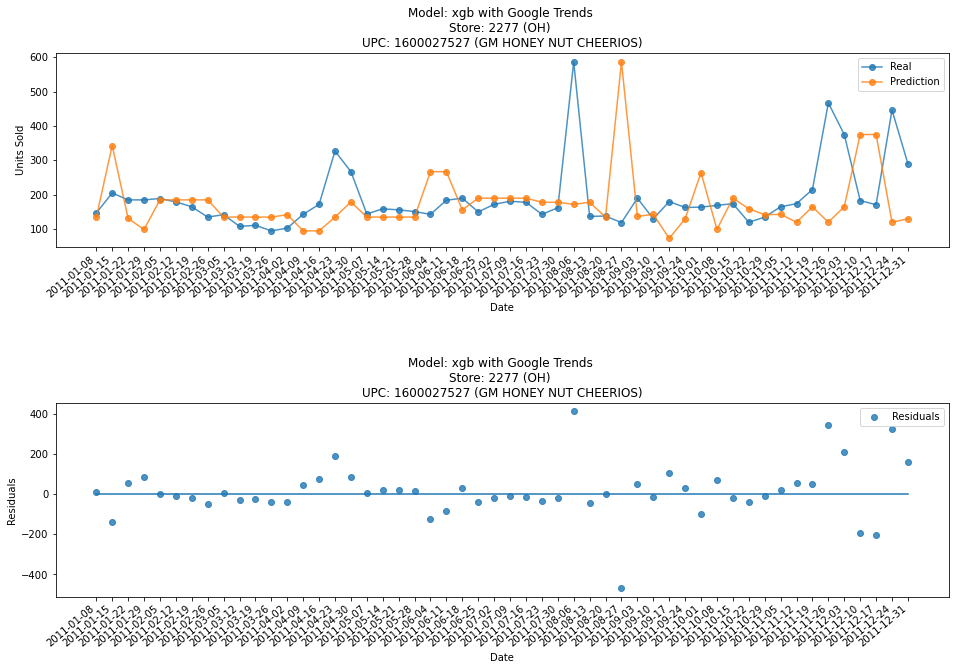

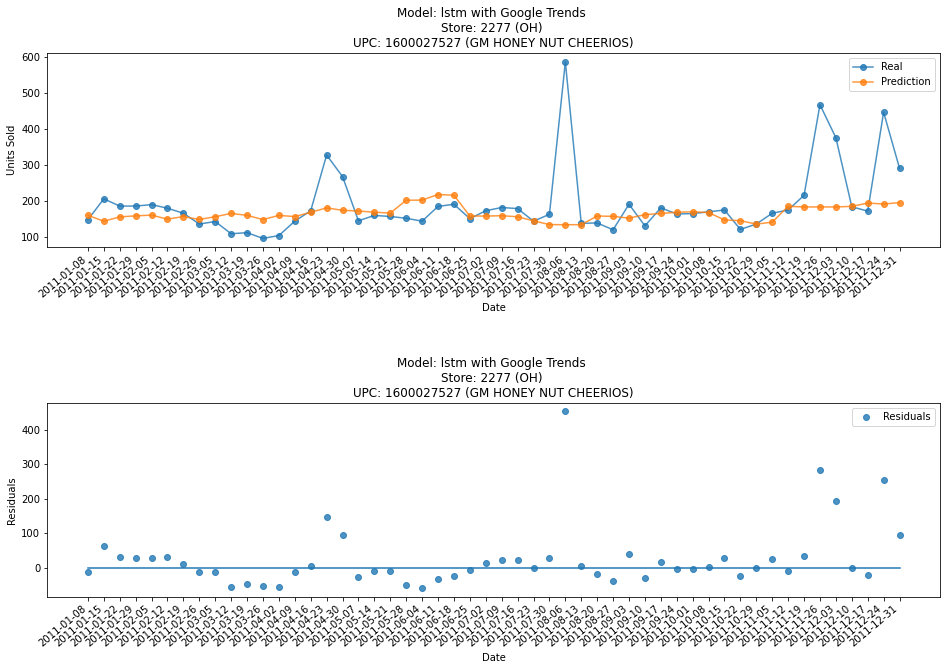

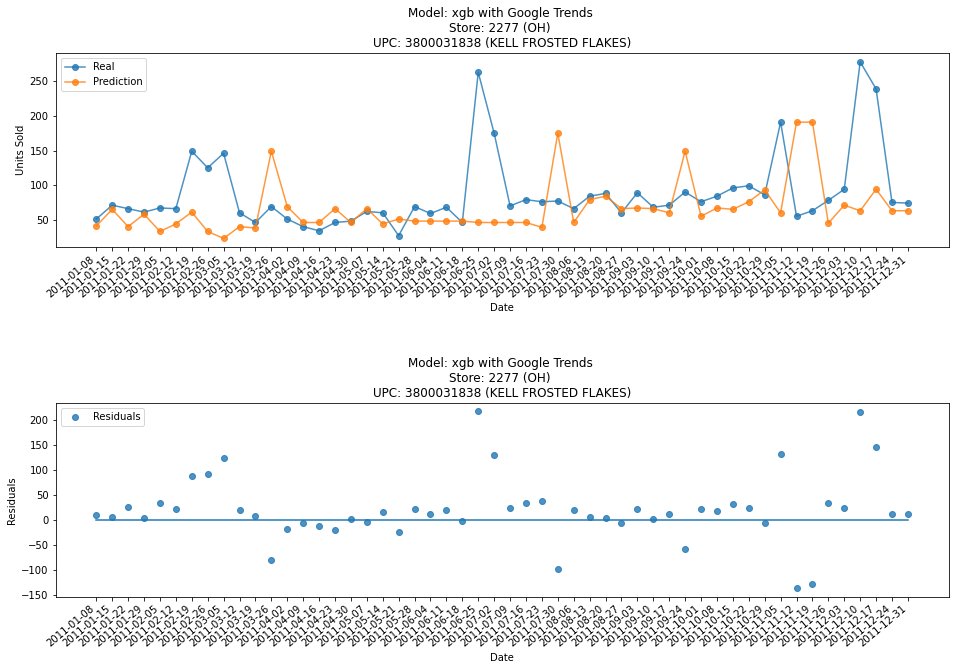

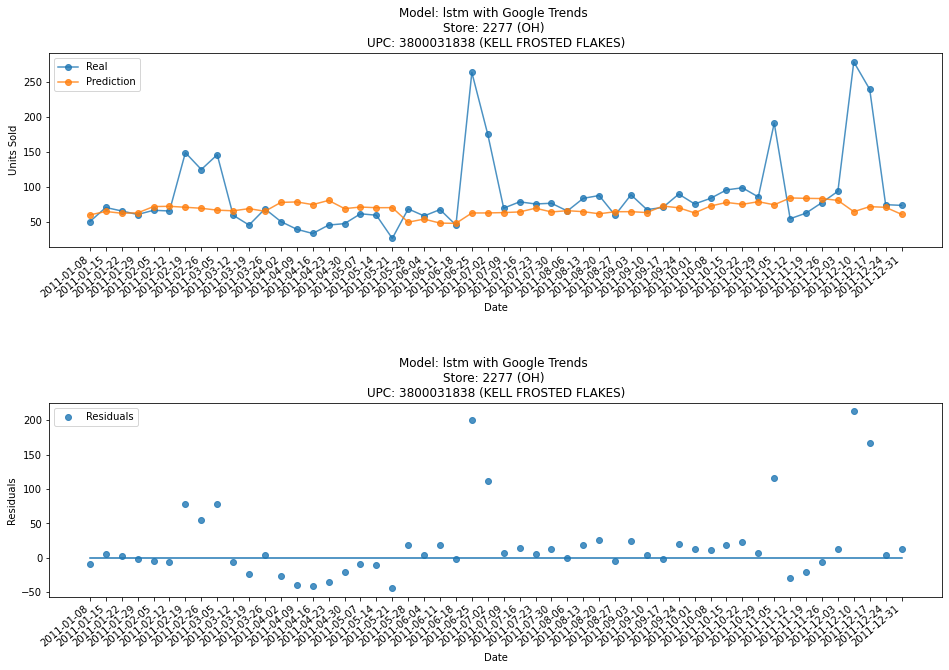

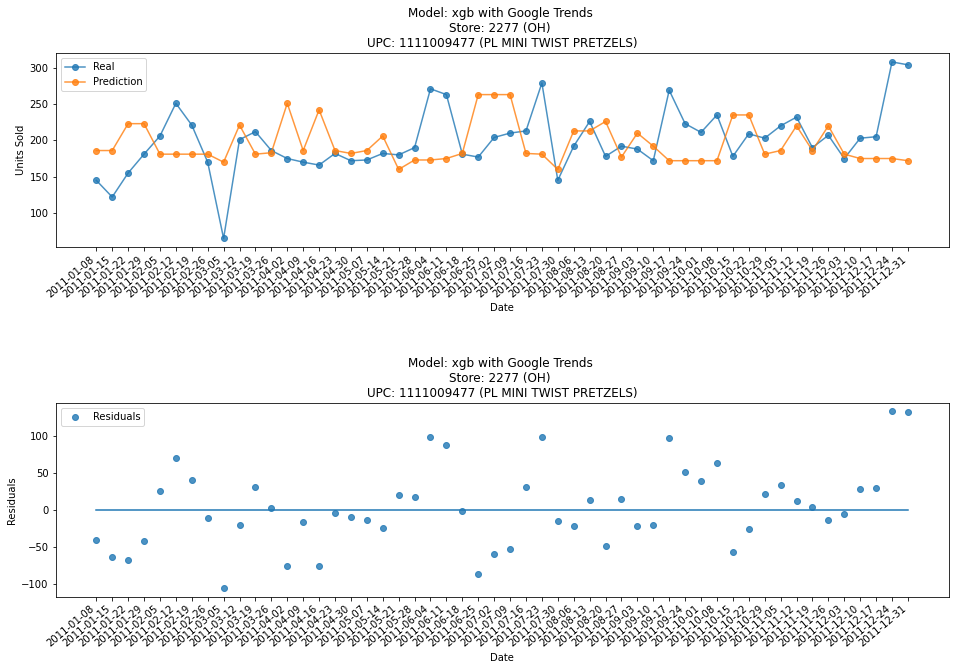

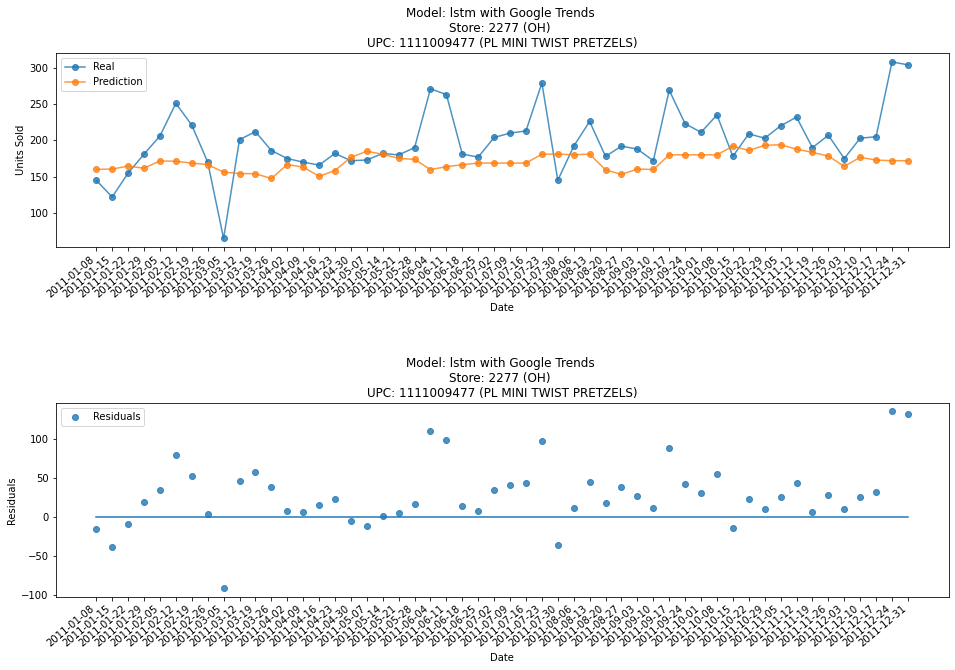

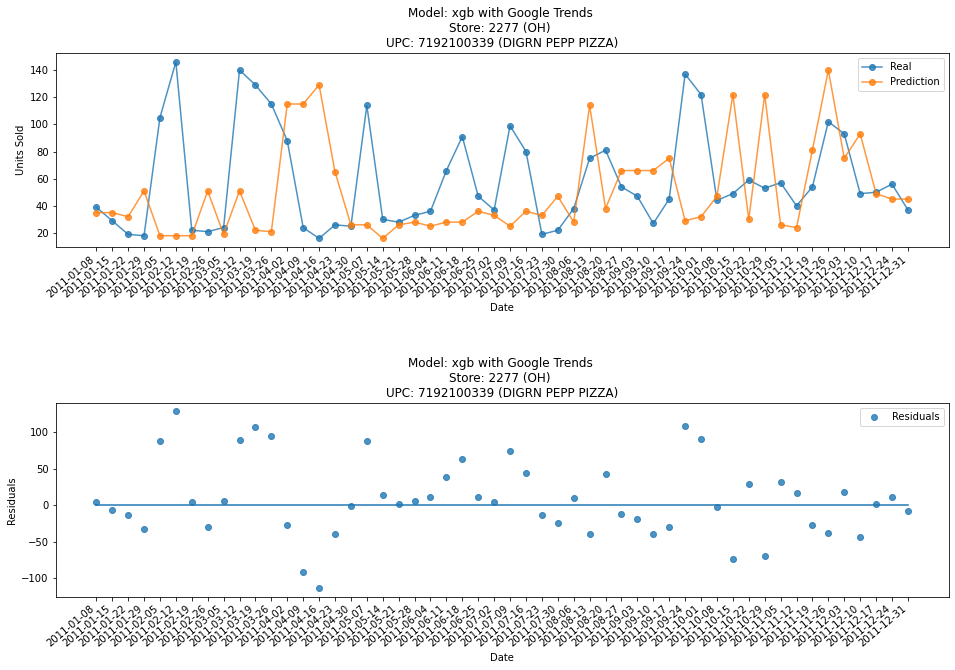

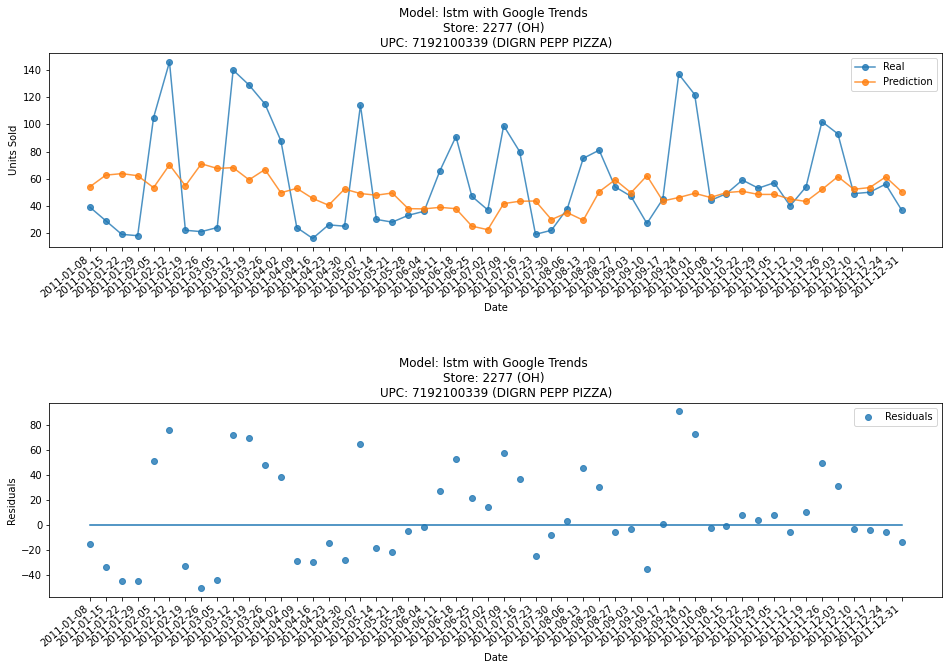

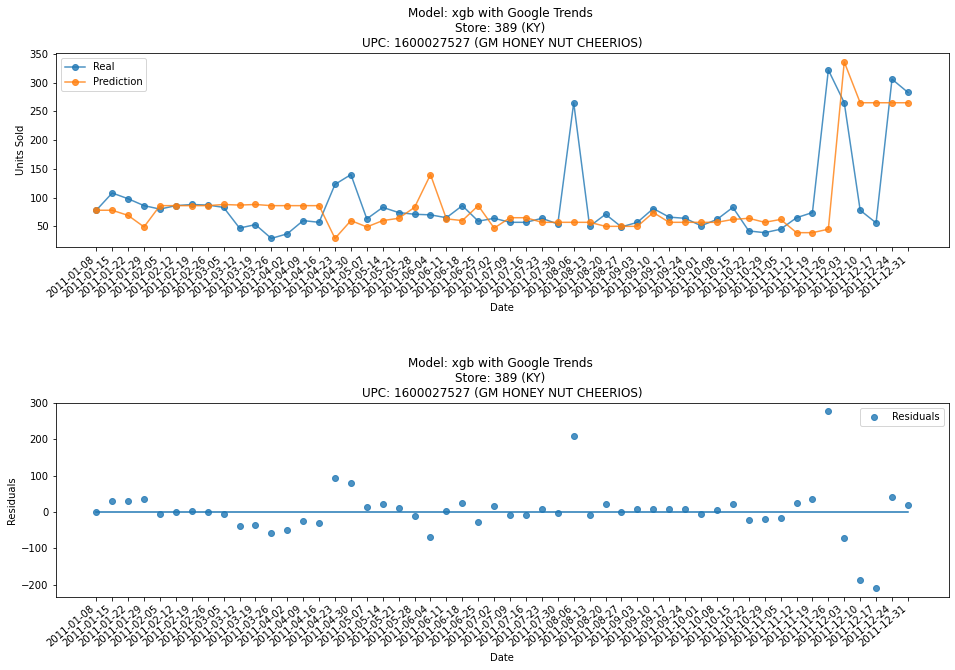

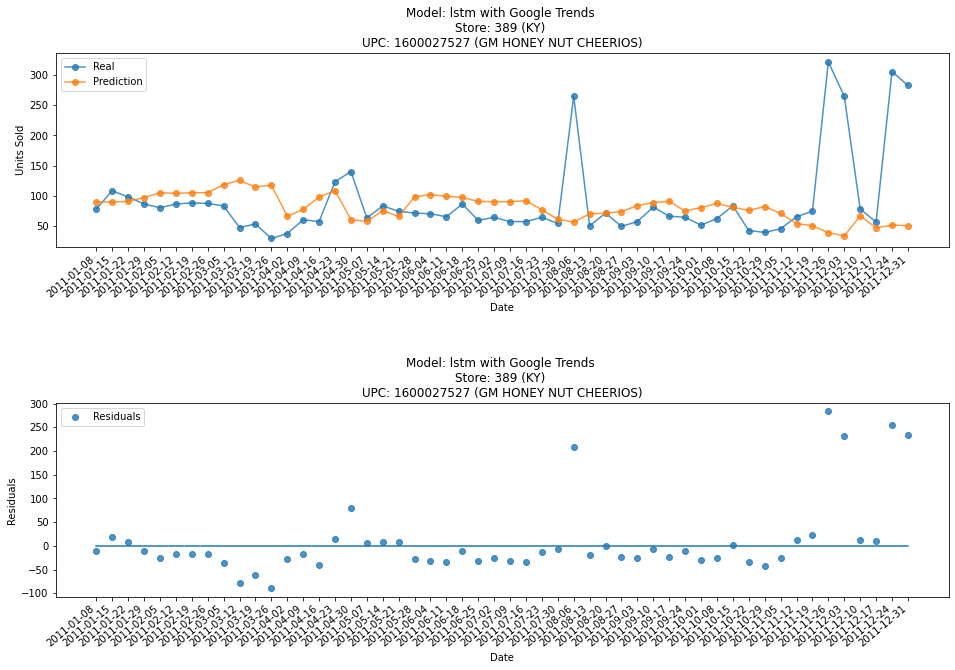

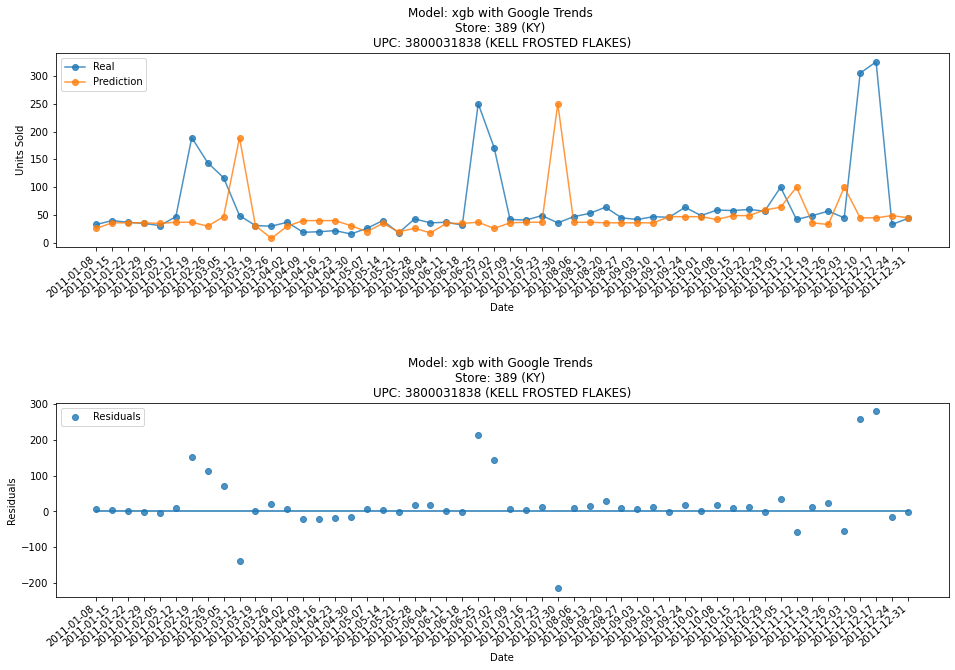

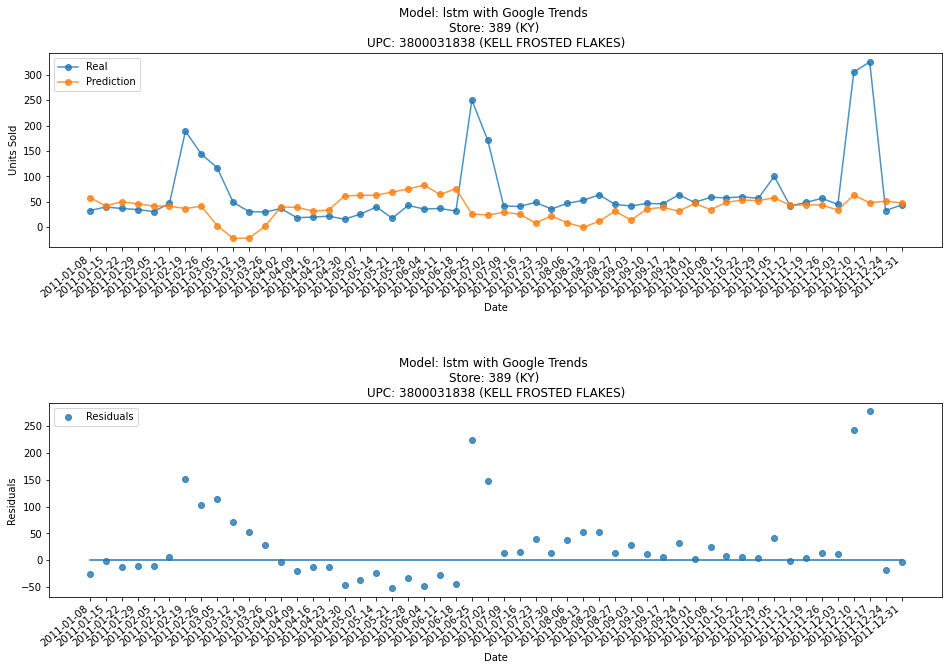

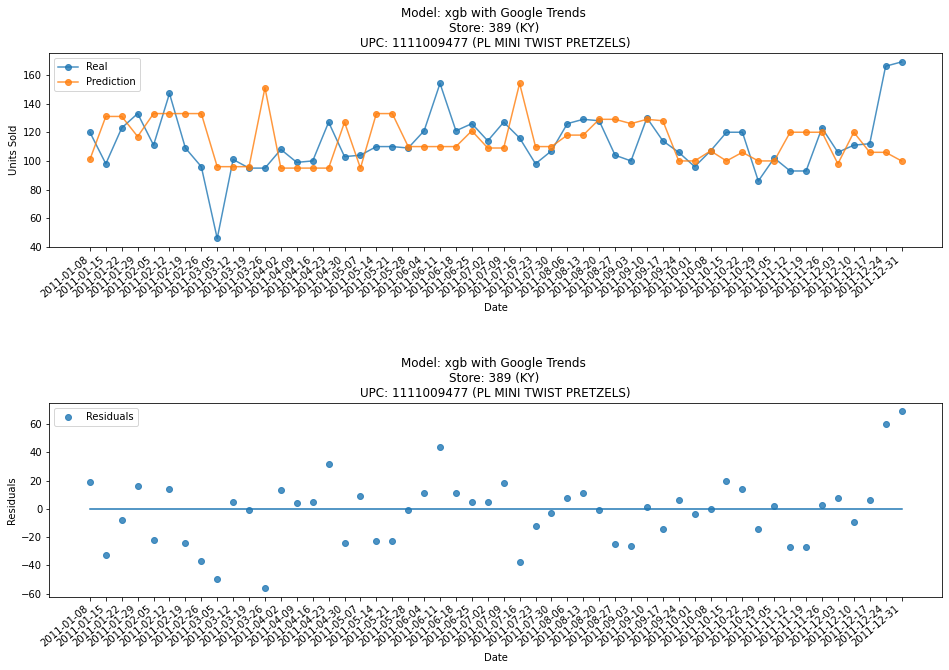

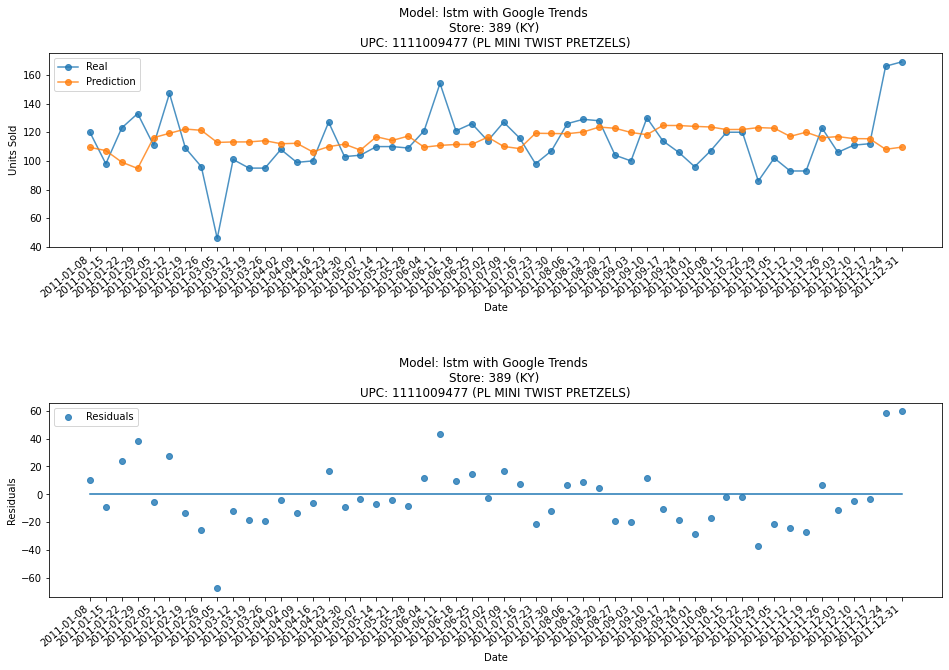

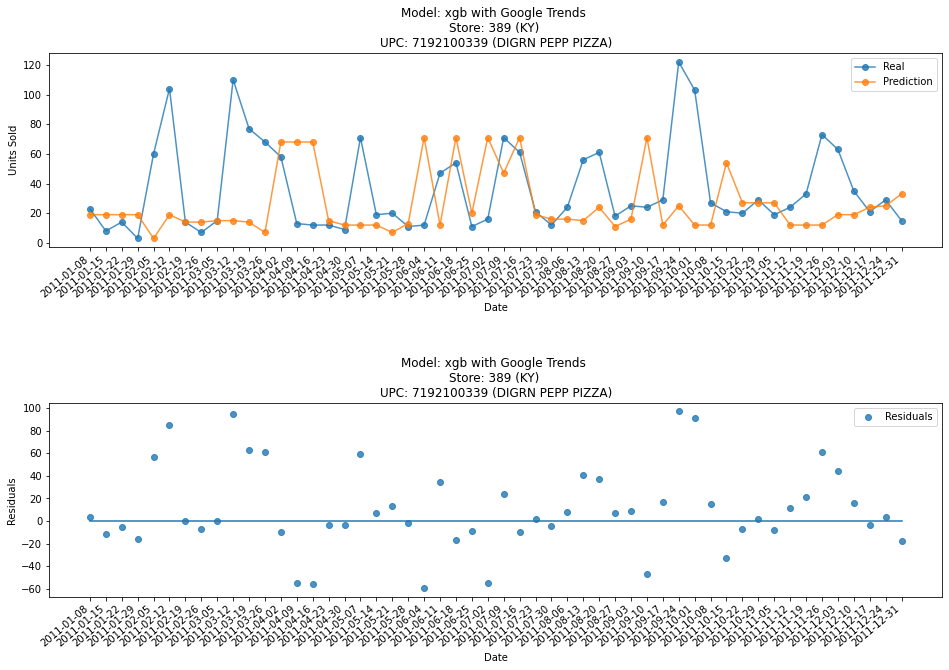

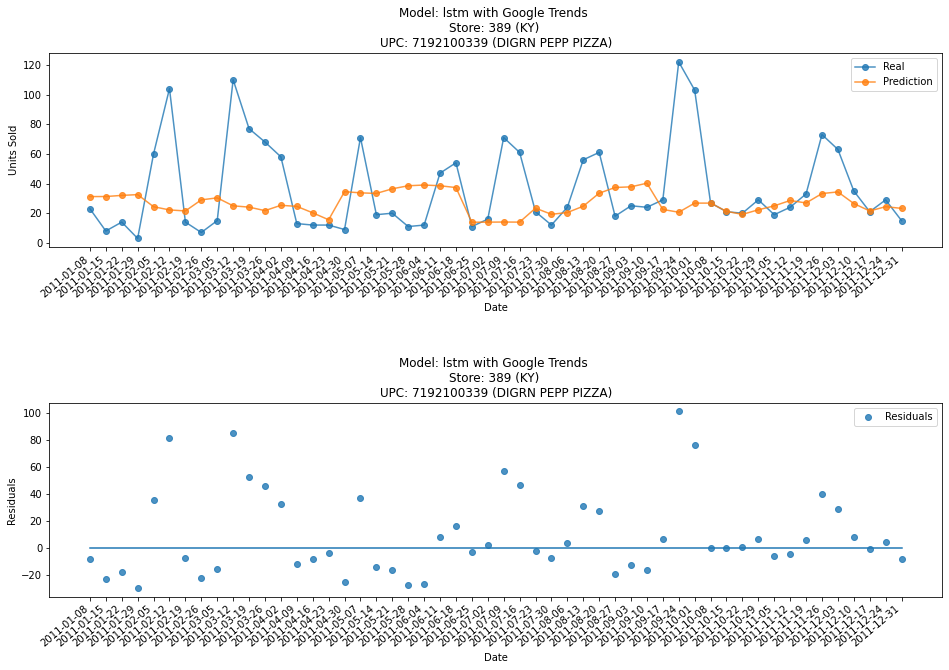

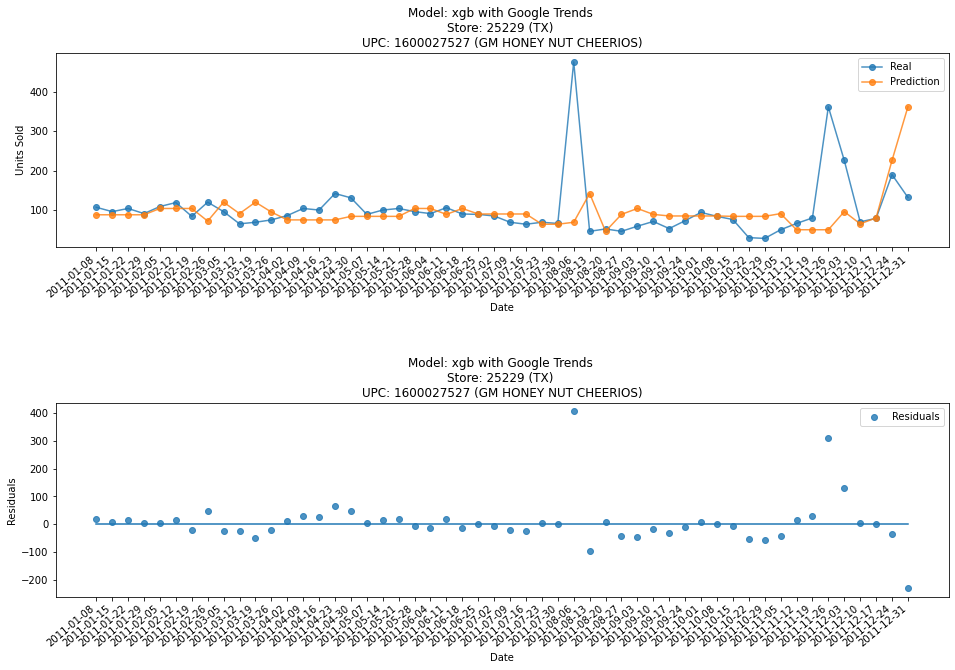

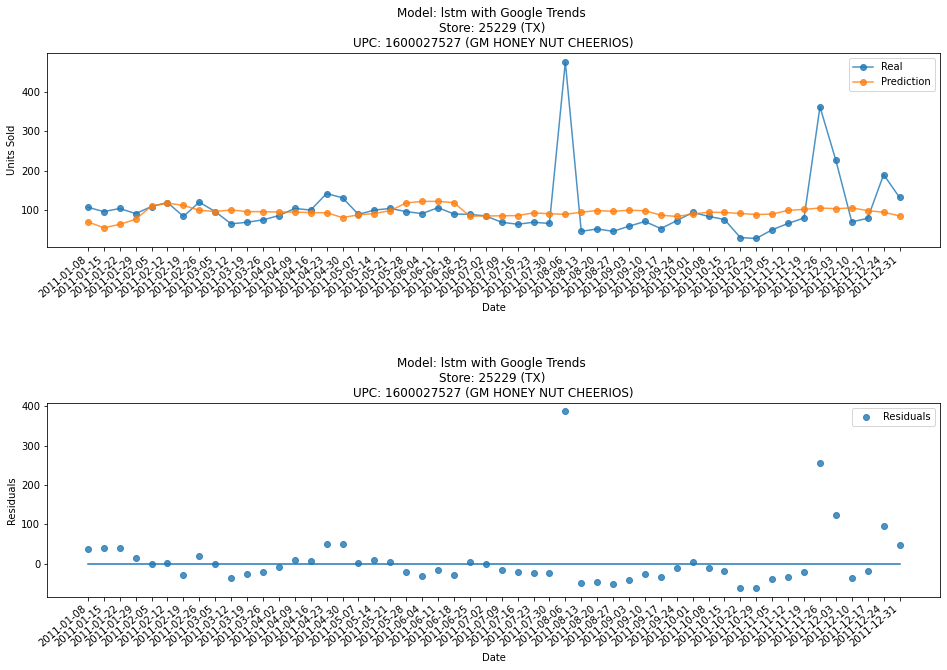

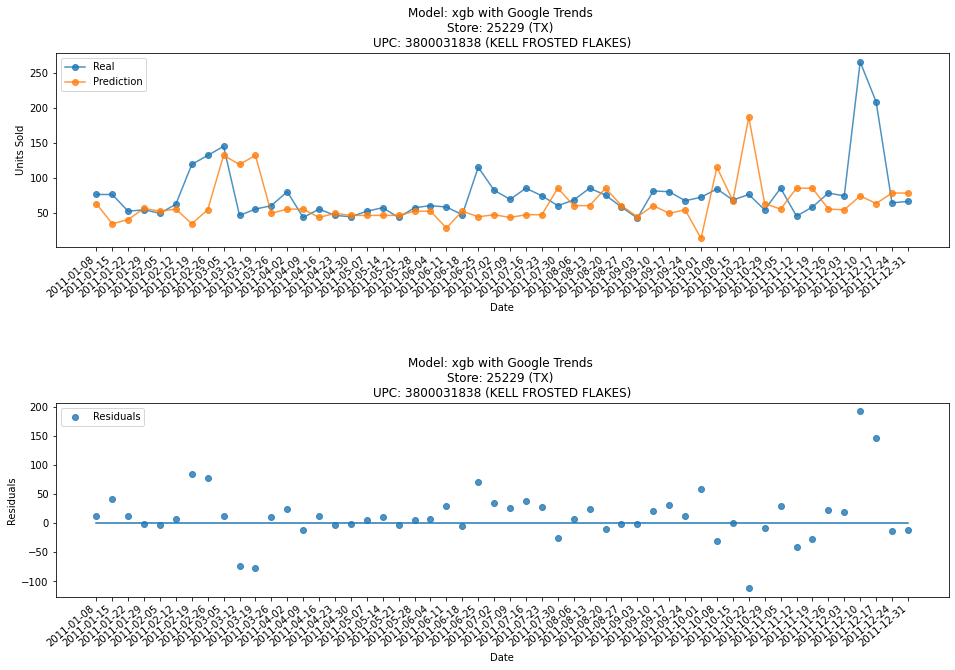

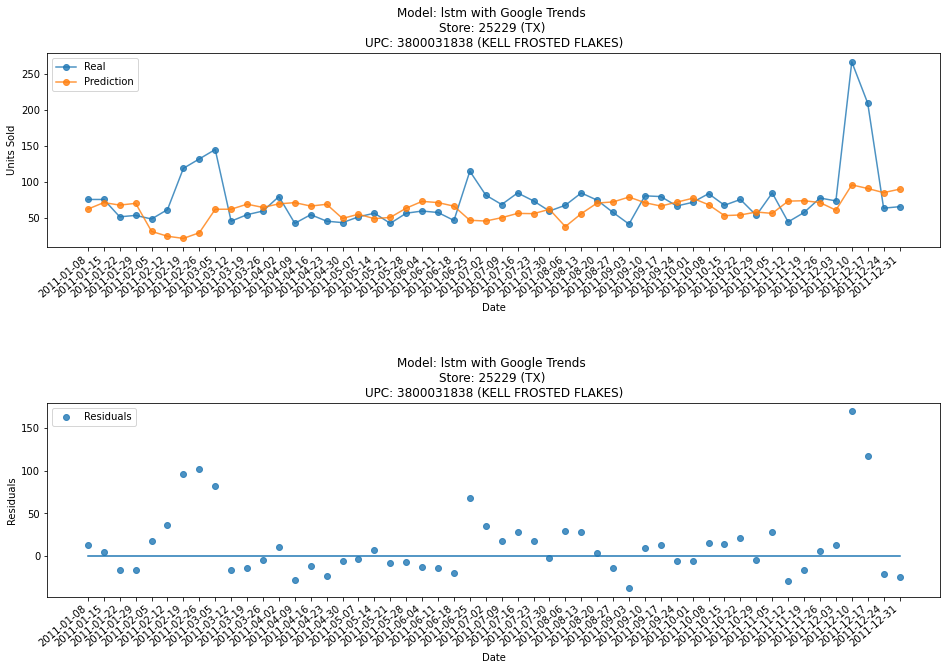

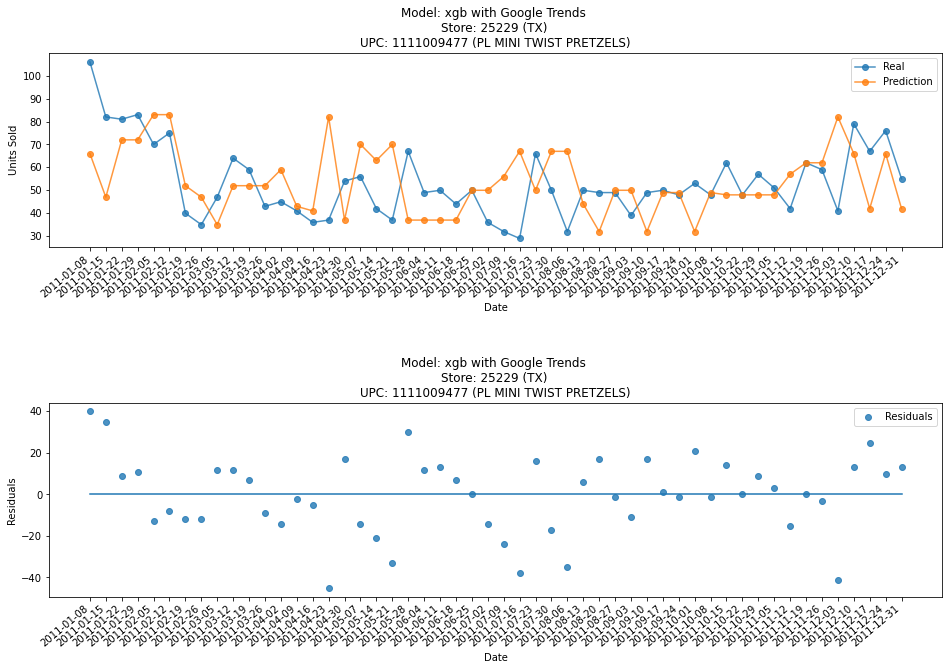

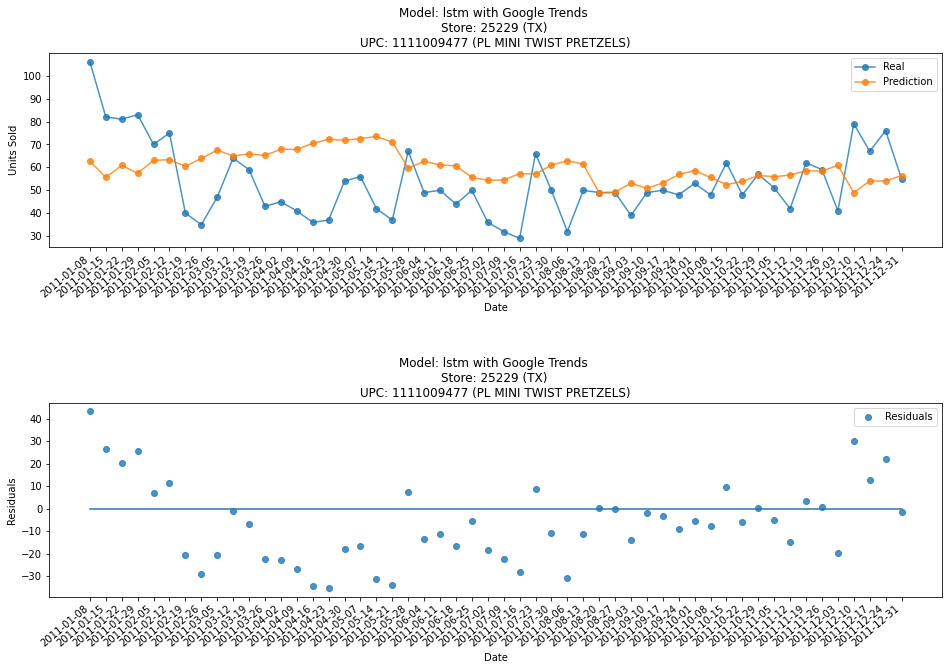

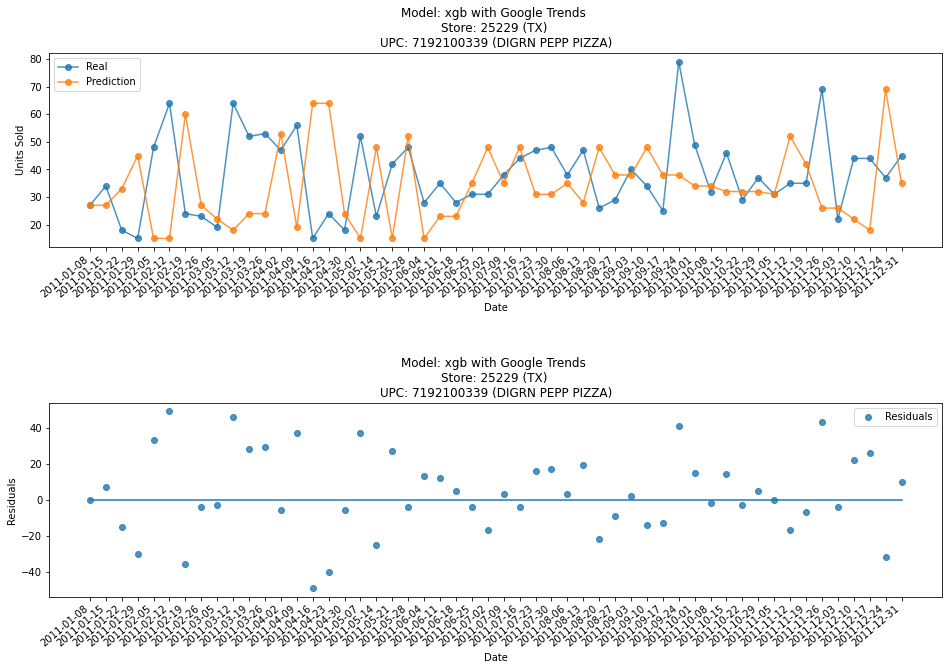

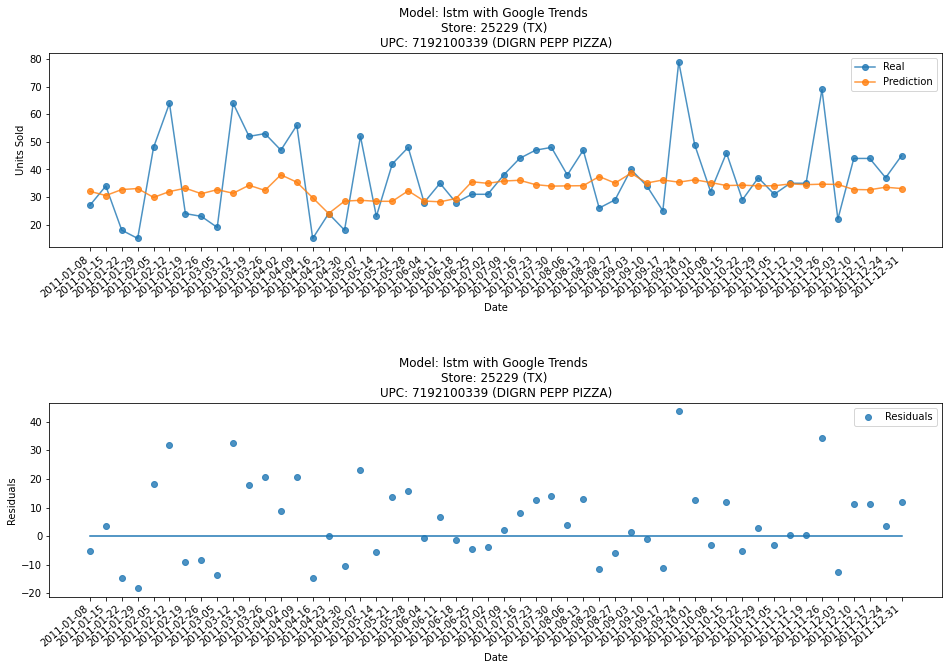

In [123]:
# Plot the forecast for each model (Only Google Trends)
for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        
        fig, axs = plt.subplots(2, 1, figsize=(16,10))
        plt.subplots_adjust(hspace=0.8)
        
        # Forecast
        axs[0].plot(temp['y_true'], marker='o', label='Real',alpha=0.8)
        axs[0].plot(temp[f'y_pred_{model}_gtrend'], marker='o', label='Prediction',alpha=0.8)
        axs[0].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Units Sold')
        axs[0].legend()
        for tick in axs[0].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        # Residuals
        axs[1].scatter(x=temp.index, y=(temp['y_true'] - temp[f'y_pred_{model}_gtrend']), marker='o', label='Residuals', alpha=0.8)
        axs[1].plot([0]*temp.shape[0])
        axs[1].set_title(f'Model: {model} with Google Trends \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Residuals')
        axs[1].legend()
        for tick in axs[1].get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
            
        plt.show()
        
    print('\n\n\n')

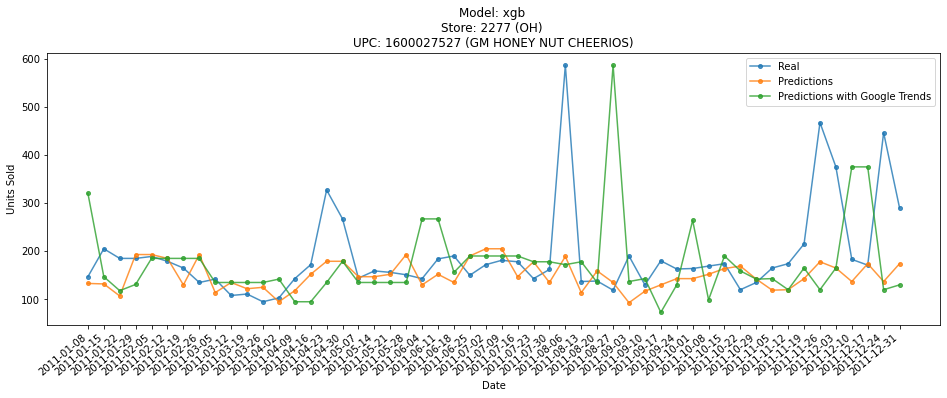

Std xgb: 28.85 and with Google Trends: 84.82


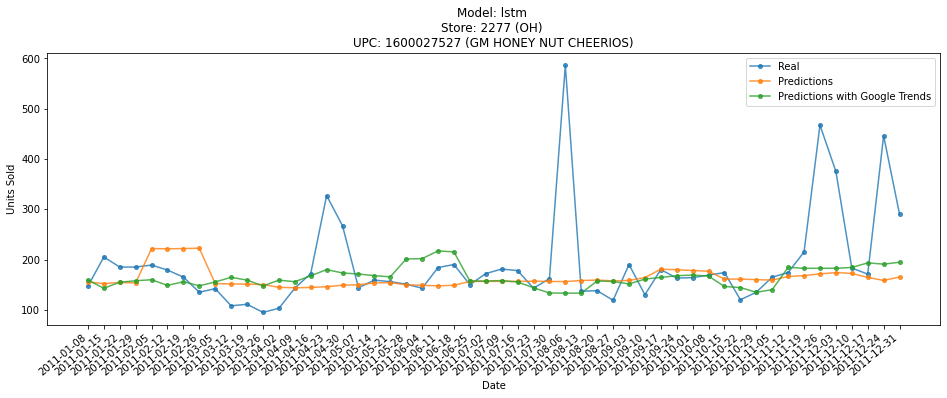

Std lstm: 19.40 and with Google Trends: 20.06






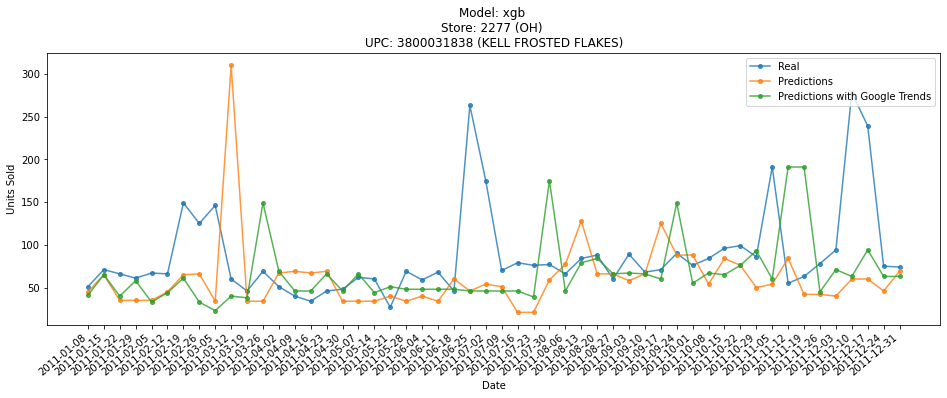

Std xgb: 41.64 and with Google Trends: 37.83


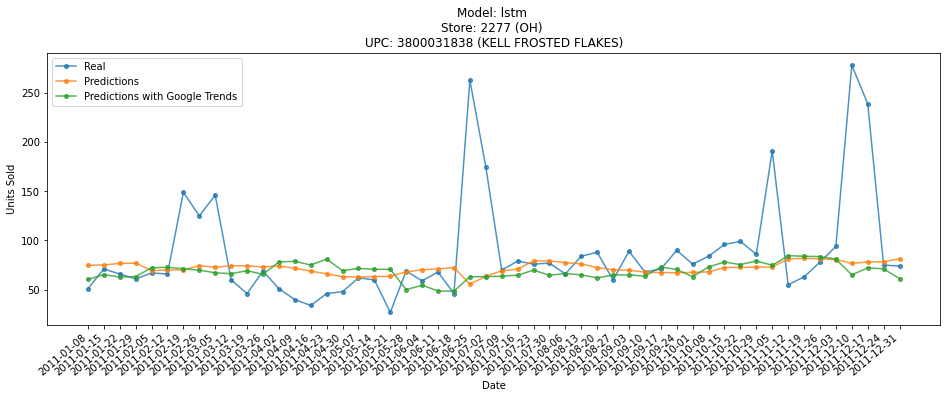

Std lstm: 5.62 and with Google Trends: 8.28






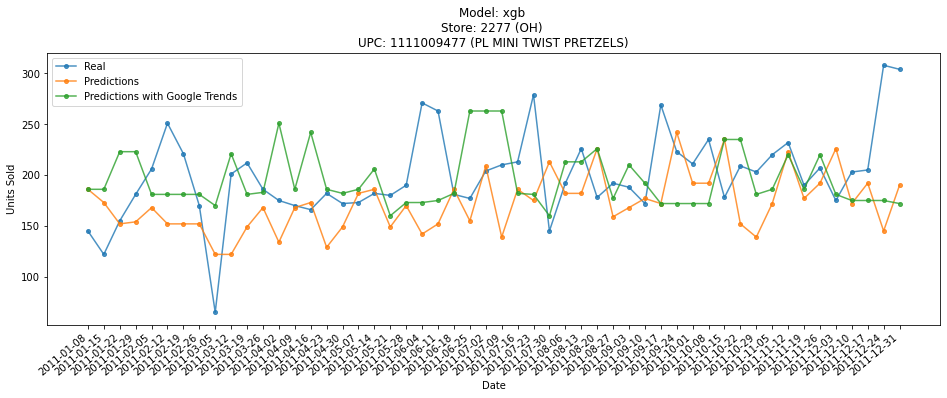

Std xgb: 28.13 and with Google Trends: 27.74


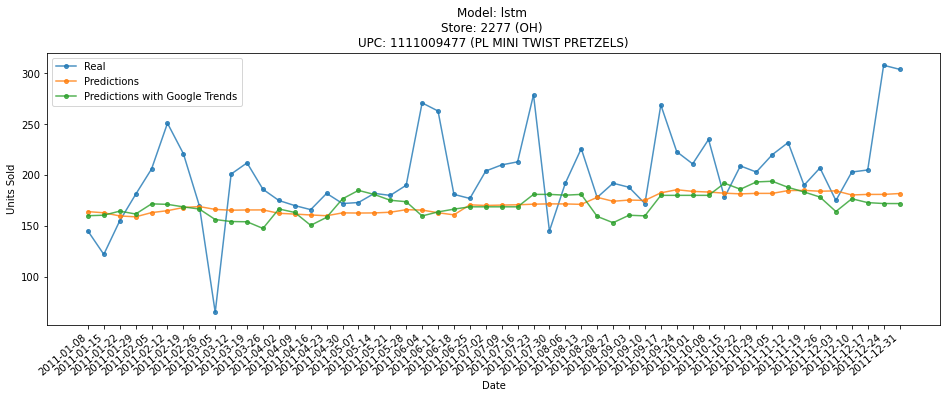

Std lstm: 8.68 and with Google Trends: 11.38






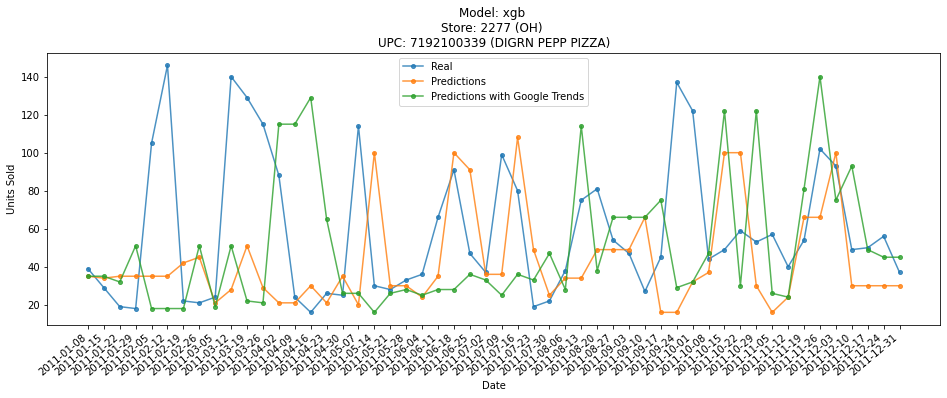

Std xgb: 25.43 and with Google Trends: 33.84


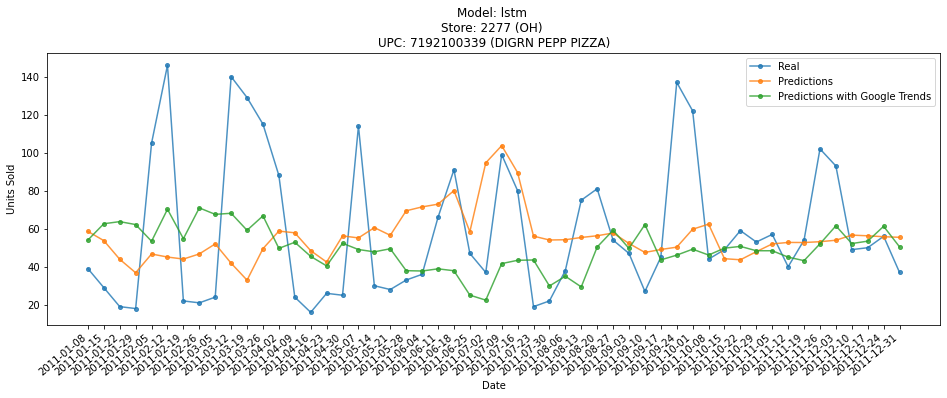

Std lstm: 13.17 and with Google Trends: 11.16






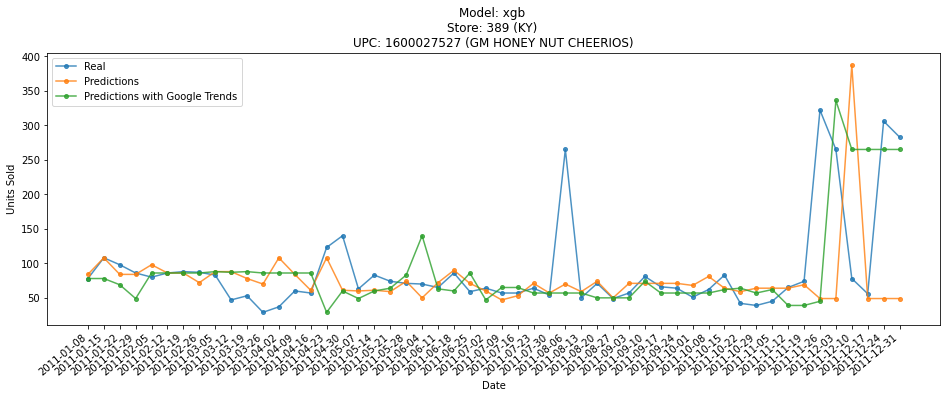

Std xgb: 46.65 and with Google Trends: 66.38


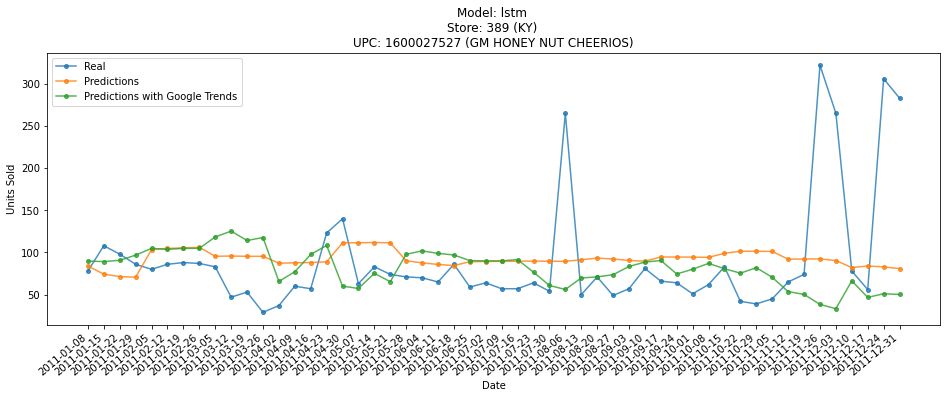

Std lstm: 9.34 and with Google Trends: 21.44






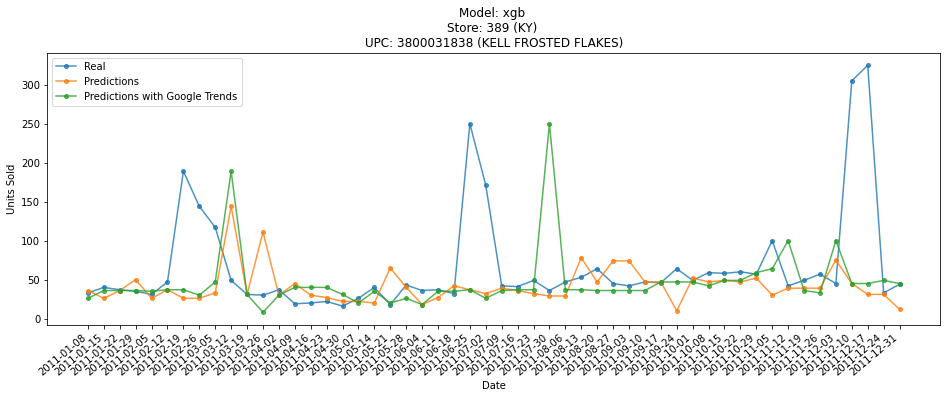

Std xgb: 23.20 and with Google Trends: 38.70


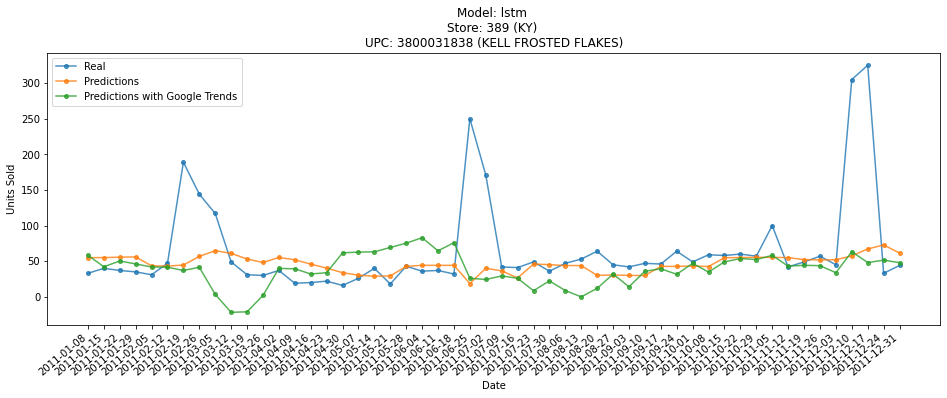

Std lstm: 11.39 and with Google Trends: 22.64






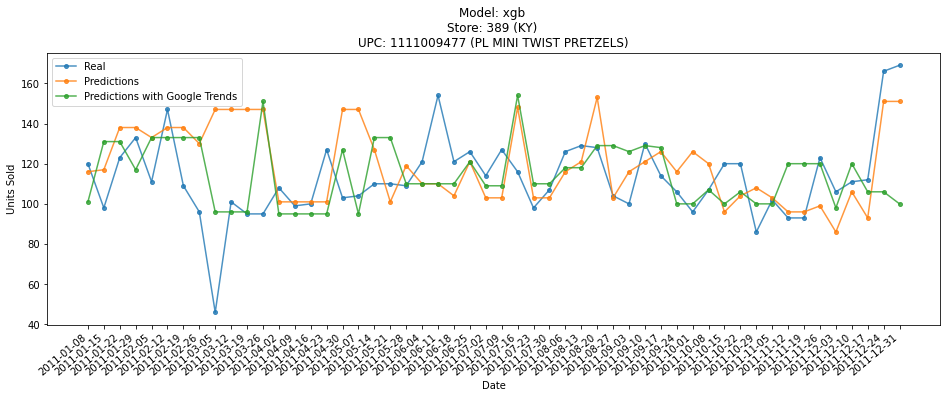

Std xgb: 19.06 and with Google Trends: 15.27


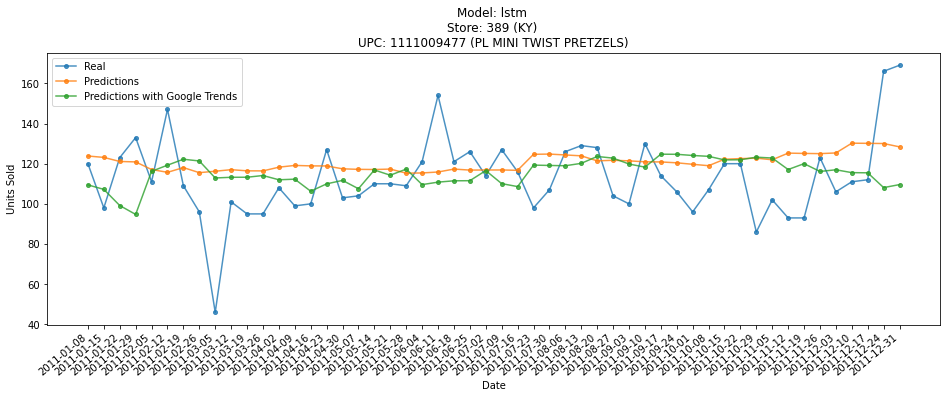

Std lstm: 4.08 and with Google Trends: 6.46






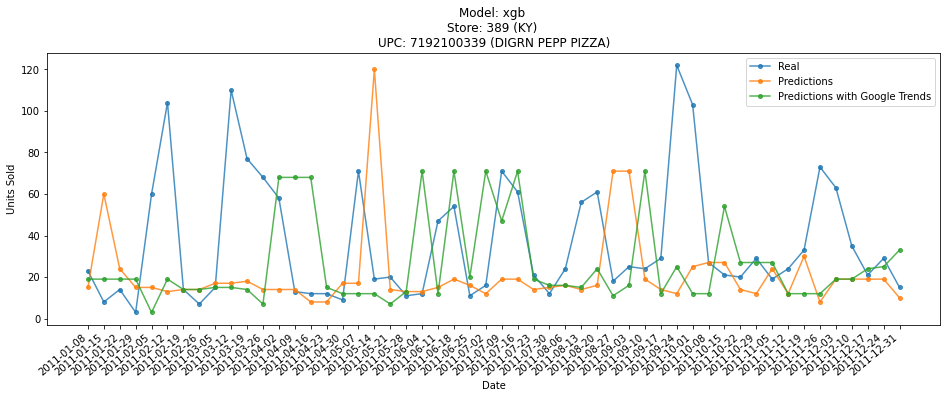

Std xgb: 19.05 and with Google Trends: 20.75


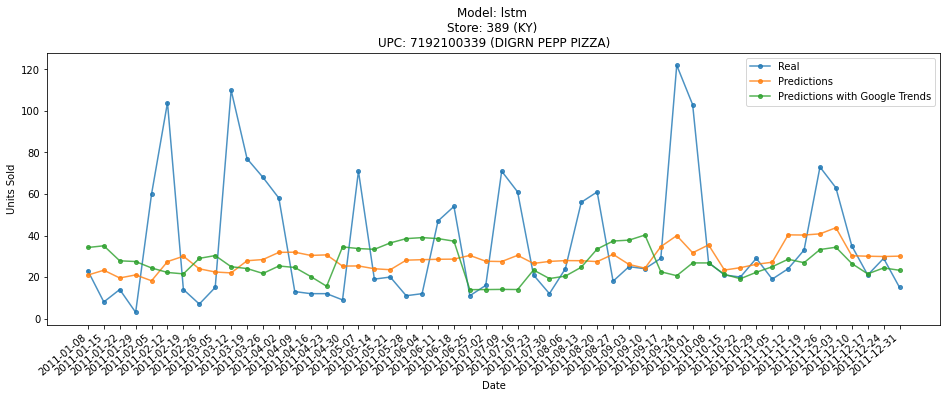

Std lstm: 5.46 and with Google Trends: 7.31






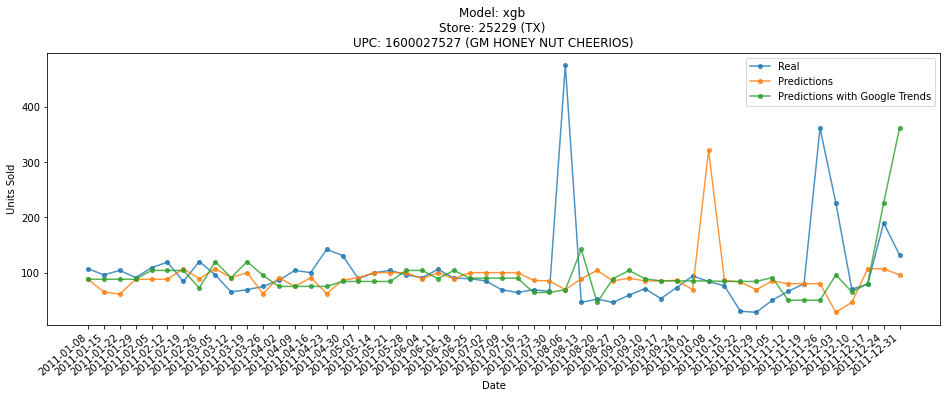

Std xgb: 36.25 and with Google Trends: 46.11


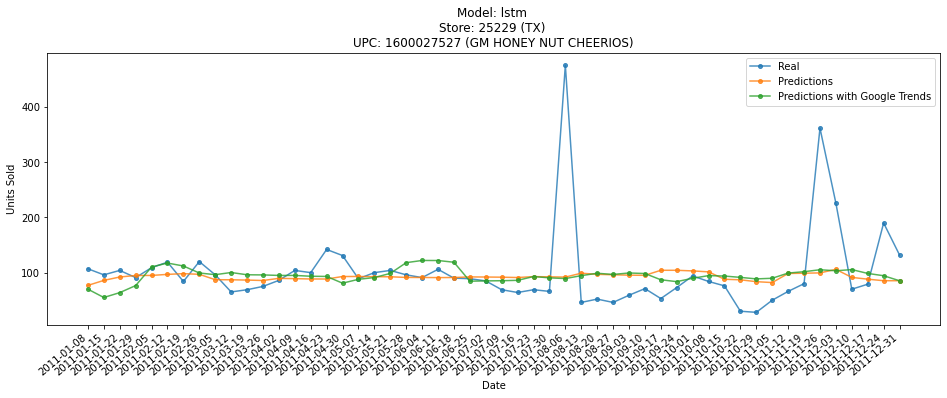

Std lstm: 5.94 and with Google Trends: 13.07






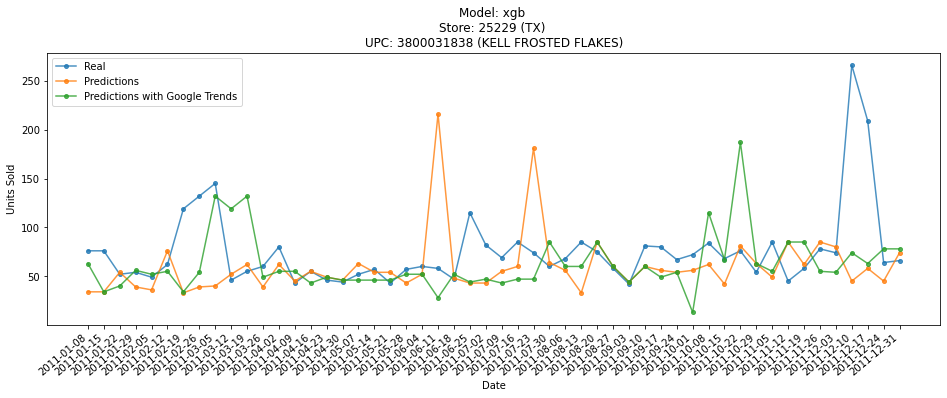

Std xgb: 31.43 and with Google Trends: 29.49


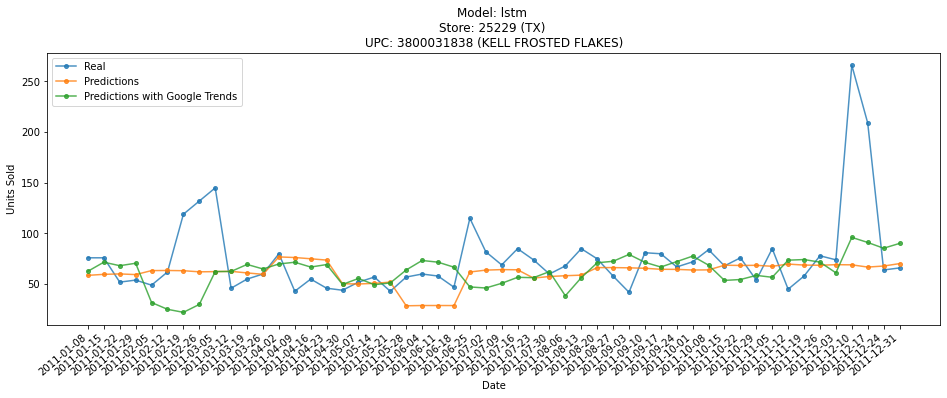

Std lstm: 11.17 and with Google Trends: 15.47






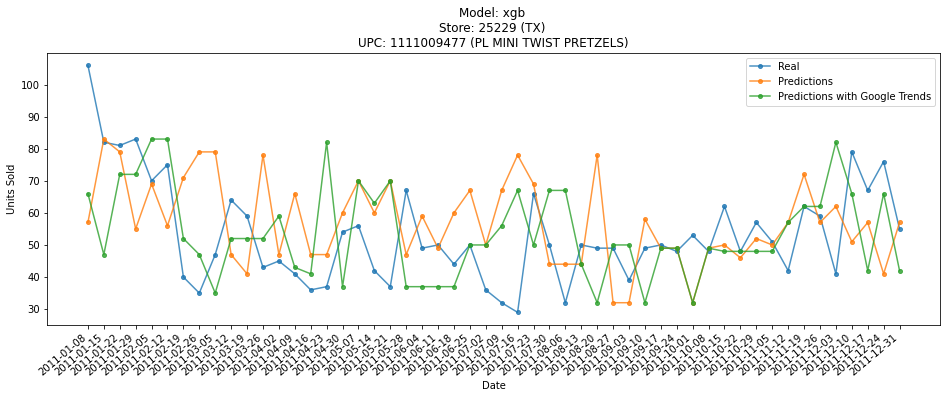

Std xgb: 13.15 and with Google Trends: 13.96


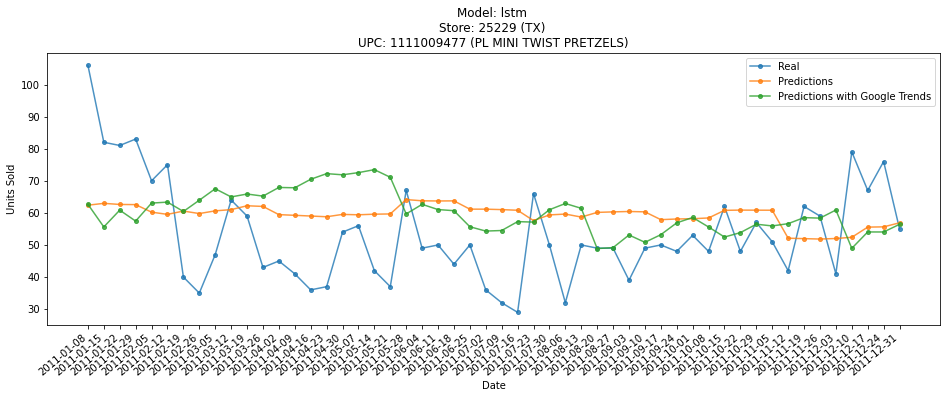

Std lstm: 3.07 and with Google Trends: 6.43






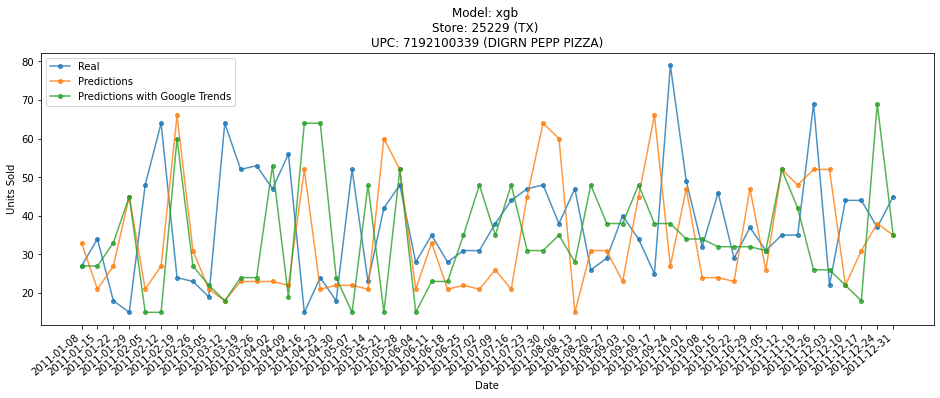

Std xgb: 14.55 and with Google Trends: 13.77


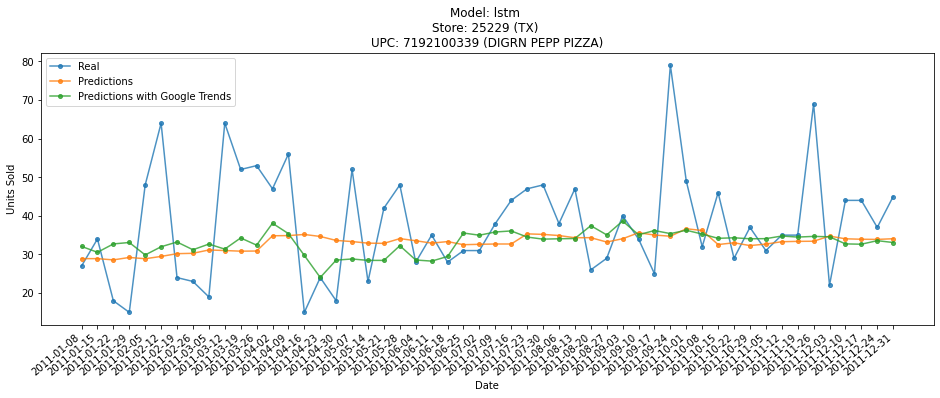

Std lstm: 2.03 and with Google Trends: 2.88






In [97]:
# Plot the forecast for each model

for store, upc in full_search:
    
    temp = all_stores_upc[f'{store}_{upc}']
    temp.sort_index(inplace=True)

    for model in ['xgb','lstm']:
        
        fig, axs = plt.subplots(1,1, figsize=(16,5))
#         plt.figure(figsize=(16,8))
        plt.plot(temp['y_true'], marker='o', markersize=4, 
                 label='Real',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}'], marker='o', markersize=4, 
                 label='Predictions',alpha=0.8)
        plt.plot(temp[f'y_pred_{model}_gtrend'], marker='o', markersize=4, 
                 label='Predictions with Google Trends',alpha=0.8)

        upc_name = lookup_products[lookup_products['UPC']==upc]['DESCRIPTION'].iloc[0]
        store_state = params['breakfast']['dataset']['store_ids'][store]
        plt.title(f'Model: {model} \nStore: {store} ({store_state}) \nUPC: {upc} ({upc_name})')
        plt.xlabel('Date')
        plt.ylabel('Units Sold')
        plt.legend()
        for tick in axs.get_xticklabels():
            tick.set_rotation(40)
            tick.set_horizontalalignment('right')
        plt.show()
        if model == 'xgb':
            print(f"Std xgb: {temp['y_pred_xgb'].std():.2f} and with Google Trends: {temp['y_pred_xgb_gtrend'].std():.2f}")
        if model == 'lstm':
            print(f"Std lstm: {temp['y_pred_lstm'].std():.2f} and with Google Trends: {temp['y_pred_lstm_gtrend'].std():.2f}")
        
    print('\n\n\n')


In [66]:
# When we add google trends, there seem to be more variation in the predictions

# Statistical tests

In [23]:
from scipy import stats

In [109]:
paired_results = pd.DataFrame()

xgb_gtrend_hyp = (
    metrics_df_xgb[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)
xgb_gtrend_hyp

model                   xgb  xgb_gtrend
store upc                              
389   1111009477  26.208484   23.897618
      1600027527  87.348110   68.789674
      3800031838  76.024035   79.980406
      7192100339  40.363969   38.765816
2277  1111009477  56.648715   53.929976
      1600027527  96.616609  133.184372
      3800031838  73.455245   69.026472
      7192100339  45.950224   52.352356
25229 1111009477  20.409274   18.565373
      1600027527  86.193767   85.092823
      3800031838  54.991957   48.184940
      7192100339  21.485684   22.808146

In [110]:
paired_results['xgb'] = xgb_gtrend_hyp['xgb']
paired_results['xgb_gtrend'] = xgb_gtrend_hyp['xgb_gtrend']
paired_results['xgb - xgb_gtrend'] = paired_results['xgb'] - paired_results['xgb_gtrend']

In [111]:
summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'xgb':['-'],
                       'xgb_gtrend':['-'],
                       'xgb - xgb_gtrend': [stats.ttest_rel(xgb_gtrend_hyp['xgb'], xgb_gtrend_hyp['xgb_gtrend'])[1]]})
t_test_val.index = ['p_value']

In [112]:
paired_results.append(t_test_val)

xgb xgb_gtrend  xgb - xgb_gtrend
(389, 1111009477)    26.2085    23.8976          2.310865
(389, 1600027527)    87.3481    68.7897         18.558436
(389, 3800031838)     76.024    79.9804         -3.956372
(389, 7192100339)     40.364    38.7658          1.598153
(2277, 1111009477)   56.6487      53.93          2.718739
(2277, 1600027527)   96.6166    133.184        -36.567762
(2277, 3800031838)   73.4552    69.0265          4.428773
(2277, 7192100339)   45.9502    52.3524         -6.402133
(25229, 1111009477)  20.4093    18.5654          1.843901
(25229, 1600027527)  86.1938    85.0928          1.100944
(25229, 3800031838)   54.992    48.1849          6.807017
(25229, 7192100339)  21.4857    22.8081         -1.322462
std                  26.8438    32.4443         12.860366
average              57.1413    57.8815         -0.740158
p_value                    -          -          0.845610


# TO BE REFORMULATED

H0: xgb_gtrend and xgb are the same distribution ? If there isn't a statistical difference in the average rmse obtained between the two experiments, at the α = 0.05 level ( since the p-value is inferior to α ).

Flach, P. A. (2017). Machine learning: the art and science of algorithms that make sense of data. Cambridge: Cambridge University Press.

#### LSTM

In [122]:
paired_results = pd.DataFrame()

lstm_gtrend_hyp = (
    metrics_df_lstm[['model','rmse','store','upc']]
    .groupby(['model','store','upc'])
    .mean()
    .reset_index()
    .pivot_table(index=['store','upc'], columns=['model'], values='rmse')
)

paired_results['lstm'] = lstm_gtrend_hyp['lstm']
paired_results['lstm_gtrend'] = lstm_gtrend_hyp['lstm_gtrend'] # [100] * 12#
paired_results['lstm - lstm_gtrend'] = paired_results['lstm'] - paired_results['lstm_gtrend']

summary_stats = pd.DataFrame()
summary_stats['std'] = paired_results.std(numeric_only=True, axis=0)
summary_stats['average'] = paired_results.mean(numeric_only=True, axis=0)


paired_results = paired_results.append(summary_stats.T)

t_test_val = pd.DataFrame({'lstm':['-'],
                           'lstm_gtrend':['-'],
#                            'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], [100] * 12)[1]]})
                           'lstm - lstm_gtrend': [stats.ttest_rel(lstm_gtrend_hyp['lstm'], lstm_gtrend_hyp['lstm_gtrend'])[1]]})
t_test_val.index = ['p_value']

paired_results.append(t_test_val)

lstm lstm_gtrend  lstm - lstm_gtrend
(389, 1111009477)    20.7117     22.3306           -1.618926
(389, 1600027527)    70.3397     81.2478          -10.908142
(389, 3800031838)    68.3178     74.7623           -6.444538
(389, 7192100339)    29.7366      32.593           -2.856409
(2277, 1111009477)   48.6399     49.6486           -1.008761
(2277, 1600027527)   97.9837      94.673            3.310708
(2277, 3800031838)    55.806     57.0151           -1.209064
(2277, 7192100339)   38.5222     37.2443            1.277926
(25229, 1111009477)  16.8868     18.9935           -2.106645
(25229, 1600027527)  73.1133     73.8437           -0.730382
(25229, 3800031838)  41.1832     41.5554           -0.372249
(25229, 7192100339)  14.7312     14.4764            0.254805
std                  25.9223      26.507            3.688938
average              47.9977     49.8653           -1.867640
p_value                    -           -            0.107244